Only needed in Colab

In [ ]:
import os
mode = -1
try:
    os.getlogin() # This will return an exception if ran in Google colab
    mode = 'local'
except:
    # Install necessary files and create necessary folders (Only when ran in Google Drive)
    !pip install snntorch
    !pip install torch
    !pip install gym
    !pip install gym[box2d]
    !mkdir tmp
    !mkdir logs
    #from google.colab import drive
    #drive.mount('/content/drive')
    #!cp "/content/drive/MyDrive/Colab Notebooks/dict9 LIF" "/content/tmp/"
    mode = 'colab'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘tmp’: File exists
mkdir: cannot create directory ‘logs’: File exists


In[imports]:

In [ ]:
import gym
import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# A small method to save plots
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=resolution)

In[params]:

# Parameters ###

In [ ]:
env_name = 'LunarLander-v2'
env_name_clean = env_name.lower().replace('-','_')
filename = env_name_clean + ".png"
outfilename = env_name_clean + "scoreboard.txt"
datename = str(datetime.now()).split('.')[0].replace(' ', '_').replace('-', '_').replace(':', '_') 
scorefigname = env_name_clean + '_' + datename + '_scores.png'
epsfigname = env_name_clean + '_' + datename + '_eps_history.png'
cumfigname = env_name_clean + '_' + datename + '_cumulated_reward.png'
model_file = './tmp/'  + env_name_clean + '_dict9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(env_name_clean)
print('Datetime (clean):', datename)
print('Output file:', outfilename)
print('Model file:', model_file)
print('Running training on: ', device)
print('Environment:', mode)

Running training on:  cuda
Mode: colab


In [ ]:
lr = 0.0005 # Learning rate
epsilon = 0.2
epsilon_end = 0.01
gamma = 0.99
batch_size = 128
hidden_size = 400 # Number of hidden units per layer
n_games = 1000 # Number of games to train for
n_hrs = 4 # Number of hours to train the model for
n_rounds = 5 # Number of competitive rounds to play

# Classes

In [ ]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.95):
        super(Net, self).__init__()

        # Initialize grad objects        
        spike_grad1 = surrogate.fast_sigmoid()
        spike_grad2 = surrogate.fast_sigmoid()
        spike_grad3 = surrogate.fast_sigmoid()
        # spike_grad4 = surrogate.fast_sigmoid() # Uncomment for 4 layers

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 512)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad1)
        
        self.fc2 = nn.Linear(512, 256)
        self.lif2 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad2)

        self.fc3 = nn.Linear(256, num_outputs) # COMMENT for 4 layers
        self.lif3 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad3)

        # self.fc3 = nn.Linear(256, 128) # Uncomment for 4 layers
        # self.lif3 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad3)

        # self.fc4 = nn.Linear(128, num_outputs) # Uncomment for 4 layers
        # self.lif4 = snn.Leaky(beta=beta, learn_beta=True, threshold=1e5, reset_mechanism="none", spike_grad=spike_grad4) # Uncomment for 4 layers

    def _convert_to_spikes(self, data):
        return snn.spikegen.delta(data, threshold=0.1, padding=False, off_spike=True)

    def createGauss(self, mins, maxes, numPerDim, amplMax, dims):
        self.amplMax = amplMax
        self.numPerDim = numPerDim
        self.M = []
        self.sigma = []
        for i in range(dims):
            M, sigma = np.linspace(mins[i], maxes[i], numPerDim, retstep=True)
            self.M.append(M)
            self.sigma += [sigma, ] * self.numPerDim
        self.M = torch.tensor(np.array(self.M).reshape(-1, self.numPerDim), dtype=torch.float).to(device)
        self.sigma = torch.tensor(np.array(self.sigma).reshape(-1, self.numPerDim), dtype=torch.float).to(device)

    def gaussianCurrents(self, data):
        x = data.unsqueeze(-1).repeat([1, 1, self.numPerDim])
        return (torch.exp(-1 / 2 * ((x - self.M) / self.sigma) ** 2) * self.amplMax).reshape(data.shape[0], -1)

    def forward(self, x, num_steps=16):
        x = self.gaussianCurrents(x)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        # mem4 = self.lif3.init_leaky() # Uncomment for 4 layers

        # Record the final layer#
        spk1_rec = []
        mem1_rec = []
        
        spk2_rec = []
        mem2_rec = []
        
        spk3_rec = []
        mem3_rec = []        
        
        # spk4_rec = [] # Uncomment for 4 layers
        # mem4_rec = []  

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            
            # cur4 = self.fc4(spk3) # Uncomment for 4 layers
            # spk4, mem4 = self.lif4(cur4, mem4)
            
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
            
            # spk4_rec.append(spk4) # Uncomment for 4 layers
            # mem4_rec.append(mem4)

        return x, [torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(spk3_rec, dim=0),
                torch.stack(mem1_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(mem3_rec, dim=0)], \
               torch.stack(mem3_rec, dim=0)

In [ ]:
class Agent(object):
    def __init__(self, lr, gamma, mem_size, n_actions, epsilon, batch_size, input_dims, epsilon_dec=0.99988,
                 epsilon_end=0.01, targetUpdateSteps=20, model_file="./tmp/dict9 LIF", q_dir='tmp\\q', visualize=False,
                 low = np.array([-1.5, -1.5, -5.0, -5.0, -np.pi, -5.0, -0.0, -0.0,]).astype(np.float32), 
                 high = np.array([1.5, 1.5, 5.0, 5.0, np.pi, 5.0, 0.0, 0.0,]).astype(np.float32), gymtype = 'disc'):
        self.visualize= visualize
        self.targetUpdateSteps = targetUpdateSteps
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.stepnum = 0
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.batch_size = batch_size
        self.model_file = model_file
        self.low = low
        self.high = high
        self.gymtype = gymtype
        self.dtype = torch.float
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        gaussPerDim = 64
        hiddenSize = 300
        self.q_net = Net(input_dims[0] * gaussPerDim, hiddenSize, n_actions).to(self.device)
        self.q_net.createGauss(self.low, self.high, gaussPerDim, 1.0, input_dims[0])
        self.t_net = Net(input_dims[0] * gaussPerDim, hiddenSize, n_actions).to(self.device)
        self.t_net.createGauss(self.low, self.high, gaussPerDim, 1.0, input_dims[0])
        self.t_net.load_state_dict(self.q_net.state_dict())

        # self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr, betas=(0.9, 0.999))
        # self.q_eval = DeepQNetwork(lr, n_actions, input_dims=input_dims, name='q_eval', chkpt_dir=q_dir)
        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions), dtype=np.int8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int8)
    
    def store_transition(self, state, action, reward, state_, terminal): # Debug this... for c.c
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        actions = np.zeros(self.n_actions)
        if(self.gymtype == 'disc'):
            actions[action] = 1.0
        self.action_memory[index] = actions
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1
    
    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon: # Random action
            if(self.gymtype == 'box'):
                actions = np.random.uniform(low=-1, high=1, size=(1,4))[0] # We want size(,4) --> 1-dimensional not 1x4
            else:
                actions = np.random.choice(self.action_space)
        else: # Greedy action
            with torch.no_grad():
                self.q_net.eval()
                gaussX, spikes, actions = self.q_net(torch.tensor(state, dtype=self.dtype).to(self.device))
                actions = actions.cpu()[-1, 0, :].detach().numpy()
                if(self.gymtype == 'disc'):
                    action = np.argmax(actions)
                    actions = action
        return actions
    
    def learn(self):
        if self.mem_cntr > self.batch_size:
            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size else self.mem_size
            batch = np.random.choice(max_mem, self.batch_size)
            state_batch = self.state_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            terminal_batch = self.terminal_memory[batch]
            self.q_net.train()
            evalspikes, _, q_eval = self.q_net.forward(torch.tensor(state_batch, dtype=self.dtype).to(self.device))
            q_eval = q_eval[-1, :, :]
            self.t_net.eval()
            _, _, q_next = self.t_net.forward(torch.tensor(new_state_batch, dtype=self.dtype).to(self.device))
            q_next = q_next[-1, :, :]
            q_target = torch.clone(q_eval).detach()
            
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = (
                    torch.tensor(reward_batch, device=self.device) + torch.tensor(self.gamma, device=self.device) \
                    * torch.max(q_next, dim=1).values * torch.tensor(terminal_batch, device=self.device)).type(
                self.dtype).detach()
            criterion = nn.MSELoss()
            loss = criterion(q_eval, q_target)
            self.optimizer.zero_grad()
            loss.backward()
            for param in self.q_net.parameters():
                if param.grad is not None:
                    param.grad.data.clamp_(-1, 1)
            self.optimizer.step()
            self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_end else self.epsilon_end
            if self.stepnum % self.targetUpdateSteps == 0:
                self.t_net.load_state_dict(self.q_net.state_dict())
            self.stepnum += 1
    
    def save_models(self):
        torch.save(self.q_net.state_dict(), self.model_file)
    
    def load_models(self):
        self.q_net.load_state_dict(torch.load(self.model_file, map_location=torch.device('cpu')))
        self.q_net.eval()

# Setup

In [ ]:
stime = time.time()
env = gym.make(env_name, render_mode='rgb_array')

n_actions = -1
gymtype = -1
if(type(env.action_space) == gym.spaces.box.Box):    
    n_actions = int(env.action_space.shape[0])
    gymtype = 'box'
else:
    n_actions = int(env.action_space.n)
    gymtype = 'disc'

n_input_dims = int(env.observation_space.shape[0]) # If the state space is not an 1-D vector then we need to change this

agent = Agent(gamma = gamma, epsilon = epsilon, lr = lr, input_dims = [n_input_dims], n_actions = n_actions,
              mem_size = 1000000, batch_size = batch_size, epsilon_end = epsilon_end, model_file = model_file,
              low = env.observation_space.low, high = env.observation_space.high, gymtype = gymtype)

scores = [] # Logged every episode
eps_history = [] # Logged every episode
avg_scores = [] # Logged every 10 episodes

if(os.path.exists(model_file)):
    try: 
        agent.load_models()
    except:
        !rm -rf model_file
        agent.save_models()
else:
    agent.save_models()

state = agent.q_net.state_dict()
state["lif1.beta"] = torch.tensor(0.95,dtype=torch.float).to(device)
state["lif2.beta"] = torch.tensor(0.95, dtype=torch.float).to(device)
state["lif3.beta"] = torch.tensor(0.95, dtype=torch.float).to(device)
# state["lif4.beta"] = torch.tensor(1.0, dtype=torch.float).to(device)
agent.q_net.load_state_dict(state)

print('gymtype:', gymtype)
print(agent.q_net.lif1.beta)
print('Action space:', env.action_space)
print('Observation space:', env.observation_space)
#print('High:', env.observation_space.high)
#print('Low:', env.observation_space.low)

gymtype: disc
tensor(0.9500, device='cuda:0')
Action space: Discrete(4)
Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


# Train

In [ ]:
observation_, reward, done, info, score = 0, 0, 0, 0, 0
i = -1
while i < n_games:
    i += 1
    done = False
    if i % 10 == 0 and i > 0:
        avg_score = np.mean(scores[max(0, i - 10):(i + 1)])
        avg_scores.append(avg_score)
        agent.save_models()
        print('episode:', i, '\t score:', score)
        print('average_score:',avg_score,'\t epsilon:',agent.epsilon,'\t progress:',str((i / n_games)*100)+'%')
    else:
        print('episode:', i, '\t score:', score)
    
    if(mode == 'colab'):
        observation = env.reset()
    else:
        observation, _ = env.reset()
    
    score = 0
    while not done:
        if i % 5 == 0:
            env.render()
        
        action = agent.choose_action(observation)
        
        if(mode == 'colab'):
            observation_, reward, done, info = env.step(action)
        else:
            observation_, reward, done, info, _ = env.step(action)
        
        score += reward
        agent.store_transition(observation, action, reward, observation_, int(done))
        observation = observation_
        agent.learn()
    scores.append(score)
    eps_history.append(agent.epsilon)

episode: 0 	 score: 0
episode: 1 	 score: -141.4604047523369
episode: 2 	 score: -125.70831239986015
episode: 3 	 score: -233.898114013845
episode: 4 	 score: -73.7096505450427
episode: 5 	 score: -182.12872420716727
episode: 6 	 score: -93.25858929129082
episode: 7 	 score: 140.99065778181443
episode: 8 	 score: -148.2867817393041
episode: 9 	 score: -92.1411810505905
episode: 10 	 score: -91.15762558524952
average_score: -104.07587258028725 	 epsilon: 0.16008485357174868 	 progress: 1.0%
episode: 11 	 score: -359.08566200776477
episode: 12 	 score: -102.48546879402211
episode: 13 	 score: -236.23343296919933
episode: 14 	 score: -135.06525857999176
episode: 15 	 score: 26.951843099131708
episode: 16 	 score: -281.1843186053716
episode: 17 	 score: -255.09788646783267
episode: 18 	 score: -330.05511501459614
episode: 19 	 score: -117.52312892500099
episode: 20 	 score: -157.7084471660424
average_score: -194.748687543069 	 epsilon: 0.13558707364792383 	 progress: 2.0%
episode: 21 	 sco

# Plot

Total time:  27354.267541885376
Saving figure lunarlander_v2_2022_11_16_16_48_07_scores.png


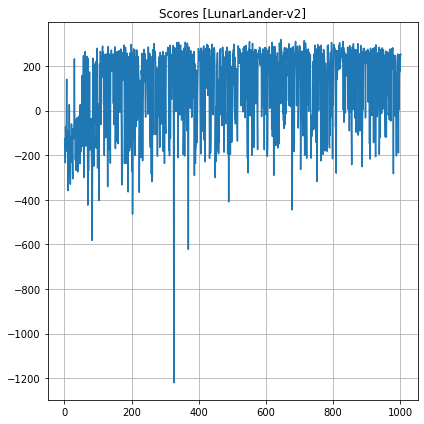

In [ ]:
print("Total time: ", time.time() - stime)

x = [idx + 1 for idx in range(len(scores))]

plt.figure(figsize=(6,6))
plt.plot(x, scores)
plt.title('Scores [' + env_name + ']')
plt.grid()
save_fig(scorefigname)
plt.show()

Saving figure lunarlander_v2_2022_11_16_16_48_07_cumulated_reward.png


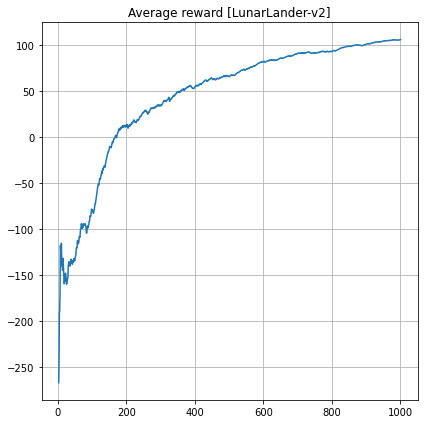

In [ ]:
c_reward = np.cumsum(scores)
c_indices = np.arange(len(c_reward))
rolling_avg = c_reward / c_indices

plt.figure(figsize=(6,6))
plt.plot(x, rolling_avg)
plt.title('Average reward [' + env_name + ']')
plt.grid()
save_fig(cumfigname)
plt.show()

Saving figure lunarlander_v2_2022_11_16_16_48_07_eps_history.png


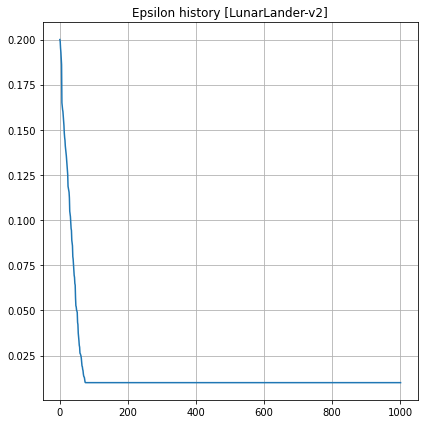

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(x, eps_history)
plt.title('Epsilon history [' + env_name + ']')
plt.grid()
save_fig(epsfigname)
plt.show()

# Log

In [ ]:
dfname = datename + '_runlogs'
df_path = 'logs/' + env_name_clean + '_' + dfname + '.csv'
df_avg_path = 'logs/' + env_name_clean + '_' + dfname + '_avg.csv'

df = pd.DataFrame({'score': scores, 'Epsilon': eps_history})
df_avg = pd.DataFrame({'avg_score': avg_scores})

df.to_csv(df_path, sep = ';', header = True, index = False)
df_avg.to_csv(df_avg_path, sep = ';', header = True, index = False)

print("Done logging results")

Done logging results


# Eval

In [ ]:
print('Starting competitive trials...')
compscores = 0
agent.load_models()
print('epsilon', agent.epsilon)

Starting competitive trials...
epsilon 0.01


In [ ]:
for i in range(n_rounds):
    done = False
    
    if(mode == 'colab'):
        observation = env.reset()
    else:
        observation, _ = env.reset()
    
    score = 0
    while not done:
        env.render()
        action = agent.choose_action(observation)
        if(mode == 'colab'):
            observation_, reward, done, info = env.step(action)
        else:
            observation_, reward, done, info, _ = env.step(action)
        agent.store_transition(observation, action, reward, observation_, int(done))
        observation = observation_
        score += reward
    compscores += score
    print("Competitive round ", i + 1, " Overall score ", compscores)

Competitive round  1  Overall score  112.18175089463183
Competitive round  2  Overall score  339.28980606019326
Competitive round  3  Overall score  347.5085431702582
Competitive round  4  Overall score  176.2081946141409
Competitive round  5  Overall score  437.4098571516542


# Score

In [ ]:
with open(outfilename, "w") as f:
    f.writelines("%s: %i\n" % (env_name_clean, compscores))

In [ ]:
if(mode == 'colab'):
    from google.colab import files
    files.download(model_file)
    files.download(outfilename)
    files.download(df_path)
    files.download(df_avg_path)
    files.download('images/' + scorefigname)
    files.download('images/' + epsfigname)
    files.download('images/' + cumfigname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>